In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("rte.csv", encoding="ISO-8859-1")

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")

# Filter data from '02-01-2020' onwards
df = df[df['Date'] >= "2020-01-02"]

# Ensure 'Heures' is a string before concatenation
df['Heures'] = df['Heures'].astype(str)

# Combine 'Date' and 'Heures' into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Heures'])

# Keep only 'Datetime' and 'E' columns
df = df[['Datetime', 'E']]

# Remove rows where 'E' is NaN or 0
df = df.dropna(subset=['E'])  # Remove NaN values
df = df[df['E'] != 0.0]        # Remove zero values

# Set 'Datetime' as index
df.set_index('Datetime', inplace=True)
df.interpolate(method='linear', inplace=True)
# Resample to 1-hour intervals, averaging 'E'
df = df.resample('1H').mean().reset_index()

# Display the cleaned dataset
df.head()




,Datetime,E
0,2020-01-02 00:00:00,62395.0
1,2020-01-02 01:00:00,59103.0
2,2020-01-02 02:00:00,58237.5
3,2020-01-02 03:00:00,55913.0
4,2020-01-02 04:00:00,54627.0


In [3]:

# 📌 Step 3: Normalize the "E" column (0-1 scale)
scaler = MinMaxScaler()
df["E"] = scaler.fit_transform(df[["E"]])

In [4]:
# 📌 Step 4: Create Sequences for LSTM
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data.iloc[i : i + timesteps]["E"].values)  # Past `timesteps` values
        y.append(data.iloc[i + timesteps]["E"])  # Next value to predict
    return np.array(X), np.array(y)

In [5]:
timesteps = 6 # Using past 12 time steps (6 hours)
X, y = create_sequences(df, timesteps)
# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)
# 📌 Step 5: Train-Test Split (80% train, 20% test)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]\
# Reshape X for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], timesteps, 1))
X_test = X_test.reshape((X_test.shape[0], timesteps, 1))

In [55]:
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(timesteps, 1)),  # First LSTM layer
    Dropout(0.3),  # Dropout for regularization
    LSTM(128, return_sequences=False),  # Second LSTM layer
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(1)  # Output layer (Predicting a single value)
])

c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

# 📌 Step 7: Compile Model
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse")

# 📌 Step 8: Train Model
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1, validation_data=(X_test, y_test))

# 📌 Step 9: Make Predictions
predictions = model_lstm.predict(X_test)
# 📌 Step 10: Convert Predictions Back to Original Scale
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
#predictions = scaler.inverse_transform(predictions)

# 📌 Step 11: Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)*100
r2 = r2_score(y_test, predictions)
print("result of SGSC LSTM")
print(f"\n✅ RMSE: {rmse:.2f}")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ R² Score: {r2:.4f}") 

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0010 - val_loss: 0.0010
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
result of SGSC LSTM

✅ RMSE: 0.03
✅ MAPE: 5.15%
✅ R² Score: 0.9569


In [59]:
# Build RNN Model
timesteps = 2
model_rnn = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(timesteps, 1)),
    Dropout(0.2),
    SimpleRNN(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model_rnn.compile(optimizer='adam', loss='mse')

# Train model
model_rnn.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model_rnn.predict(X_test)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ R² Score: {r2:.4f}")

Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0298 - val_loss: 0.0030
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 10/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0017 - val_loss: 0.0012
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
✅ RMSE: 1864.03
✅ MAPE: 2.65%
✅ R² Score: 0.9507


In [64]:
timesteps = 12
# Build GRU Model
model_GRU = Sequential([
    GRU(50, activation='relu', return_sequences=True, input_shape=(timesteps, 1)),
    Dropout(0.2),
    GRU(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model_GRU.compile(optimizer='adam', loss='mse')

# Train model
model_GRU.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model_GRU.predict(X_test)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ R² Score: {r2:.4f}")

Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0258 - val_loss: 0.0039
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 9/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 10/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0023 - val_loss: 0.0015
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
✅ RMSE: 2059.61
✅ MAPE: 2.87%
✅ R² Score: 0.9398


In [68]:
# Build BLSTM Model
timesteps=12
model_BLSTM = Sequential([
    Bidirectional(LSTM(50, activation='relu', return_sequences=True), input_shape=(timesteps, 1)),
    Dropout(0.2),
    Bidirectional(LSTM(50, activation='relu')),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model_BLSTM.compile(optimizer='adam', loss='mse')

# Train model
model_BLSTM.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model_BLSTM.predict(X_test)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ R² Score: {r2:.4f}")

Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0278 - val_loss: 0.0045
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0016 - val_loss: 0.0015
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
✅ RMSE: 2087.76
✅ MAPE: 2.94%
✅ R² Score: 0.9381


In [72]:
# Build BRNN Model
timesteps=2
model_BRNN = Sequential([
    Bidirectional(SimpleRNN(50, activation='relu', return_sequences=True), input_shape=(timesteps, 1)),
    Dropout(0.2),
    Bidirectional(SimpleRNN(50, activation='relu')),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model_BRNN.compile(optimizer='adam', loss='mse')

# Train model
model_BRNN.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model_BRNN.predict(X_test)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ R² Score: {r2:.4f}")

Epoch 1/20


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0171 - val_loss: 0.0017
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 11/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.

In [76]:
# Build BGRU Model
timesteps=12
model_BGRU = Sequential([
    Bidirectional(GRU(50, activation='relu', return_sequences=True), input_shape=(timesteps, 1)),
    Dropout(0.2),
    Bidirectional(GRU(50, activation='relu')),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model_BGRU.compile(optimizer='adam', loss='mse')

# Train model
model_BGRU.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred = model_BGRU.predict(X_test)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ R² Score: {r2:.4f}")

Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0214 - val_loss: 0.0045
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 9/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0015 - val_loss: 0.0010
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
✅ RMSE: 1737.51
✅ MAPE: 2.37%
✅ R² Score: 0.9572


In [6]:
# Build the DeepDeFF model with RNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Flatten

# Continue your code
def build_deepdeff_rnn(input_shape):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Flatten

    model = Sequential()
    model.add(SimpleRNN(64, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))  # Dropout for regularization
    model.add(Flatten())  # Flatten the output from RNN layers
    model.add(Dense(64, activation='relu'))  # Feedforward layer
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mse')
    return model

# Now you can build and train the model
timesteps = 2  # Example, adjust based on your dataset

model_DRNN = build_deepdeff_rnn((timesteps, 1))
model_DRNN.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0242
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.8187e-04
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3167e-04
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.4641e-04


In [7]:


# Make predictions
predictions_DRNN = model_DRNN.predict(X_test)

# Inverse transform the predictions and actual values
predictions_new = predictions_DRNN.reshape(-1, 1)  
predictions_original_DRNN = scaler.inverse_transform(predictions_new)  # Inverse transform
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_original, predictions_original_DRNN))
mape = mean_absolute_percentage_error(y_test_original, predictions_original_DRNN) * 100
r2 = r2_score(y_test_original, predictions_original_DRNN)

# Print evaluation metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 4293.23
MAPE: 6.33%
R² Score: 0.7385


In [8]:
# Function to build the LSTM model using a Deep Feedforward approach
def build_deepdeff_lstm(input_shape):
    model = Sequential()
    # Add LSTM layer
    model.add(LSTM(64, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))  # Dropout layer for regularization
    model.add(LSTM(64, activation='relu'))  # Second LSTM layer
    model.add(Dropout(0.2))  # Another Dropout for regularization
    model.add(Flatten())  # Flatten the output from LSTM layers
    model.add(Dense(64, activation='relu'))  # Feedforward layer
    model.add(Dense(1))  # Output layer for regression (one continuous value)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    return model
# Now you can build and train the model
timesteps = 2 # Example, adjust based on your dataset

model_DLSTM= build_deepdeff_lstm((timesteps, 1))
model_DLSTM.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0402
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0079
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0052
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0043
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0025
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024


In [9]:
# Make predictions
predictions_DLSTM = model_DLSTM.predict(X_test)

# Inverse transform the predictions and actual values
predictions_new = predictions_DLSTM.reshape(-1, 1)  
predictions_original_DLSTM = scaler.inverse_transform(predictions_new)  # Inverse transform
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_original, predictions_original_DLSTM))
mape = mean_absolute_percentage_error(y_test_original, predictions_original_DLSTM) * 100
r2 = r2_score(y_test_original, predictions_original_DLSTM)

# Print evaluation metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 2222.22
MAPE: 3.18%
R² Score: 0.9299


In [10]:
# Function to build the GRU model using a Deep Feedforward approach
def build_deepdeff_gru(input_shape):
    model = Sequential()
    # Add GRU layer
    model.add(GRU(64, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))  # Dropout layer for regularization
    model.add(GRU(64, activation='relu'))  # Second GRU layer
    model.add(Dropout(0.2))  # Another Dropout for regularization
    model.add(Flatten())  # Flatten the output from GRU layers
    model.add(Dense(64, activation='relu'))  # Feedforward layer
    model.add(Dense(1))  # Output layer for regression (one continuous value)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    return model
# Now you can build and train the model
timesteps = 2 # Example, adjust based on your dataset

model_DGRU= build_deepdeff_gru((timesteps, 1))
model_DGRU.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0321
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0045
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0029
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0021
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0019
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0018
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0018
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0016
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015


In [11]:
# Make predictions
predictions_DGRU= model_DGRU.predict(X_test)

# Inverse transform the predictions and actual values
predictions_new = predictions_DGRU.reshape(-1, 1)  
predictions_original_DGRU = scaler.inverse_transform(predictions_new)  # Inverse transform
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_original, predictions_original_DGRU))
mape = mean_absolute_percentage_error(y_test_original, predictions_original_DGRU) * 100
r2 = r2_score(y_test_original, predictions_original_DGRU)

# Print evaluation metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
RMSE: 4943.55
MAPE: 7.04%
R² Score: 0.6532


In [12]:
# Function to build the GRU model using a Deep Feedforward approach
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Flatten, Bidirectional


def build_deepdeff_bgru(input_shape):
    model = Sequential()
    
    # First Bidirectional GRU layer
    model.add(Bidirectional(GRU(64, activation='relu', return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Second Bidirectional GRU layer
    model.add(Bidirectional(GRU(64, activation='relu')))
    model.add(Dropout(0.2))
    
    # Feedforward layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    return model
# Now you can build and train the model
timesteps = 2 # Example, adjust based on your dataset

model_DBGRU= build_deepdeff_bgru((timesteps, 1))
model_DBGRU.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0339
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0036
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0027
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0024
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0021
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0018
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0018
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0016
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0015
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0014


In [13]:
predictions_DBGRU= model_DBGRU.predict(X_test)

# Inverse transform the predictions and actual values
predictions_new = predictions_DBGRU.reshape(-1, 1)  
predictions_original_DBGRU = scaler.inverse_transform(predictions_new)  # Inverse transform
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mape = mean_absolute_percentage_error(y_test_original, predictions_original_DBGRU) * 100


# Print evaluation metrics
print(f"MAPE: {mape:.2f}%")


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
MAPE: 3.42%


In [14]:
# Function to build the GRU model using a Deep Feedforward approach
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Flatten, Bidirectional


def build_deepdeff_bLSTM(input_shape):
    model = Sequential()
    
    # First Bidirectional GRU layer
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Second Bidirectional GRU layer
    model.add(Bidirectional(LSTM(64, activation='relu')))
    model.add(Dropout(0.2))
    
    # Feedforward layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    return model
# Now you can build and train the model
timesteps = 2 # Example, adjust based on your dataset

model_DBLSTM= build_deepdeff_bLSTM((timesteps, 1))
model_DBLSTM.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0378
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0039
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0030
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0028
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0023
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0021
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0020
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0020
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0017
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0016


In [15]:
predictions_DBLSTM= model_DBLSTM.predict(X_test)

# Inverse transform the predictions and actual values
predictions_new = predictions_DBLSTM.reshape(-1, 1)  
predictions_original_DBLSTM = scaler.inverse_transform(predictions_new)  # Inverse transform
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mape = mean_absolute_percentage_error(y_test_original, predictions_original_DBLSTM) * 100


# Print evaluation metrics
print(f"MAPE: {mape:.2f}%")

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
MAPE: 3.16%


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Flatten, Bidirectional

# Function to build the BRNN model using a Deep Feedforward approach
def build_deepdeff_brnn(input_shape):
    model = Sequential()
    
    # First Bidirectional RNN layer
    model.add(Bidirectional(SimpleRNN(64, activation='relu', return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Second Bidirectional RNN layer
    model.add(Bidirectional(SimpleRNN(64, activation='relu')))
    model.add(Dropout(0.2))
    
    # Feedforward layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    return model

# Example usage:
timesteps = 2  # Adjust based on your dataset
model_DBRNN = build_deepdeff_brnn((timesteps, 1))
model_DBRNN.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10


c:\Users\Dafinny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0217
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0028
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0015
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010


In [17]:
predictions_DBRNN= model_DBRNN.predict(X_test)

# Inverse transform the predictions and actual values
predictions_new = predictions_DBRNN.reshape(-1, 1)  
predictions_original_DBRNN = scaler.inverse_transform(predictions_new)  # Inverse transform
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mape = mean_absolute_percentage_error(y_test_original,predictions_original_DBRNN) * 100


# Print evaluation metrics
print(f"MAPE: {mape:.2f}%")

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MAPE: 4.53%


In [18]:
# Create the predictions dictionary for DeepDeFF models
predictions_dict = {
    "DeepDeFF-LSTM": predictions_original_DLSTM,
    "DeepDeFF-GRU": predictions_original_DGRU,
    "DeepDeFF-RNN": predictions_original_DRNN,
    "DeepDeFF-BGRU": predictions_original_DBGRU,
    "DeepDeFF-BLSTM": predictions_original_DBLSTM,
    "DeepDeFF-BRNN": predictions_original_DBRNN
}


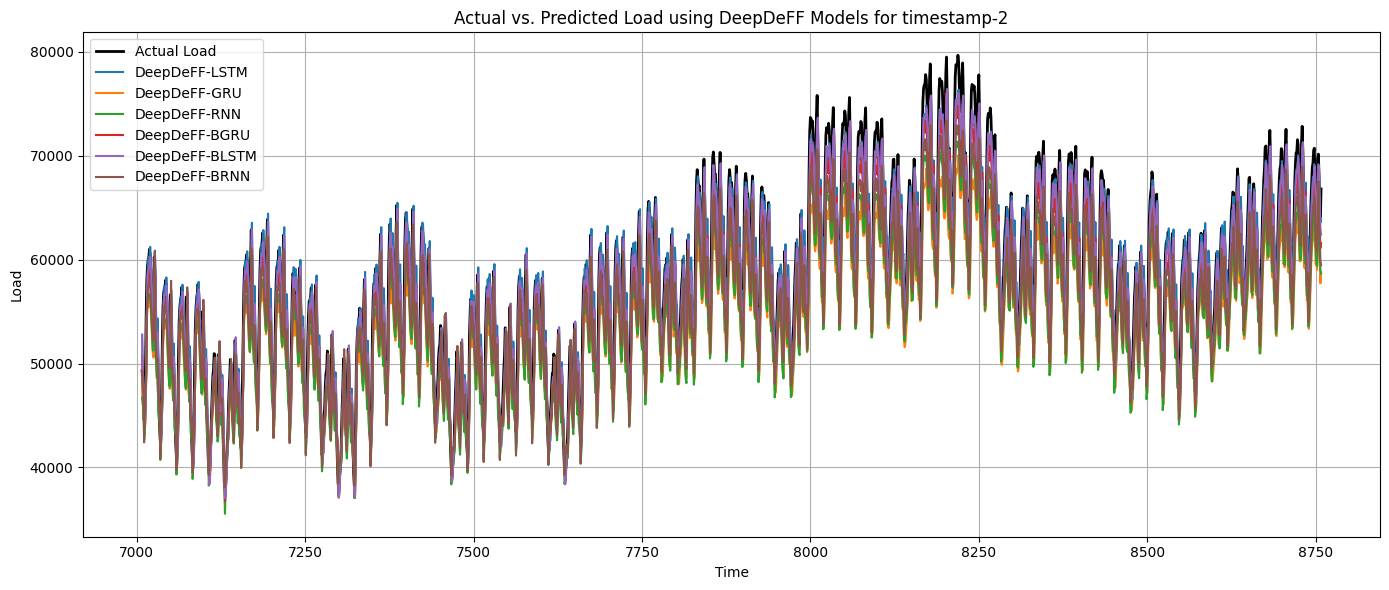

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Example structure for your predictions (replace with your actual variables)
# predictions_dict = {
#     "DeepDeFF-LSTM": lstm_preds,
#     "DeepDeFF-GRU": gru_preds,
#     "DeepDeFF-RNN": rnn_preds,
#     "DeepDeFF-BLSTM": blstm_preds,
#     "DeepDeFF-BGRU": bgru_preds,
#     "DeepDeFF-BRNN": brnn_preds
# }

# Align the date index to y_test
sequence_dates = df.index[timesteps:]                # offset for sequence generation

test_dates = sequence_dates[int(0.8 * len(sequence_dates)):]  # same 80/20 split
min_len = min(len(y_test), len(test_dates))
y_test_trimmed = y_test.flatten()[:min_len]
test_dates_trimmed = test_dates[:min_len]


# Create DataFrame for plotting
plot_df = pd.DataFrame({'E': y_test_trimmed}, index=test_dates_trimmed)

# Add each DeepDeFF model's prediction
for model_name, preds in predictions_dict.items():
    plot_df[model_name] = preds[:len(plot_df)]

# Plot
plt.figure(figsize=(14, 6))
# Assuming 'scaler' is the MinMaxScaler used on 'E'
# and 'plot_df['E']' contains the scaled values

plot_df['E_original'] = scaler.inverse_transform(plot_df[['E']])

plt.plot(plot_df.index, plot_df['E_original'], label='Actual Load', color='black', linewidth=2)

for model_name in predictions_dict:
    plt.plot(plot_df.index, plot_df[model_name], label=model_name)

plt.xlabel('Time')
plt.ylabel('Load')
plt.title('Actual vs. Predicted Load using DeepDeFF Models for timestamp-2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
